<a href="https://colab.research.google.com/github/leinaxd/Portfolio/blob/main/machine_learning/Dropout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

DROPOUT
```
Author: Eichenbaum Daniel
Email: eichenbaum.daniel@gmail.com
```

This is a practical demo for understanding the theory behind: 
  ```
  Chapter: 7.12 Dropout

  Goodellow and Bengio, 
  Deep Learning, MIT Press, 2016
  http://www.deeplearningbook.org
  ```

In this demo we will introduce Dropout as a regularizer.

Dropout mimics an ensemble method, as seen in Goodfellow, and it can be improved by several ways as seen in the book.

warning: After completing this demo i reallize Pytorch.dropout already implements the dropout rule. that's why you don't see any improvements with this rule

Source:
https://wandb.ai/authors/ayusht/reports/Implementing-Dropout-in-PyTorch-With-Example--VmlldzoxNTgwOTE

In [ ]:
import torch, torchvision
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt
import numpy as np

DOWNLOAD DATASET

In [ ]:
#Download Dataset
BATCH_SIZE = 32

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root="./data", train=True,download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root="./data", train=False,download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,shuffle=False, num_workers=2)

CLASS_NAMES = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


VISUALIZATION

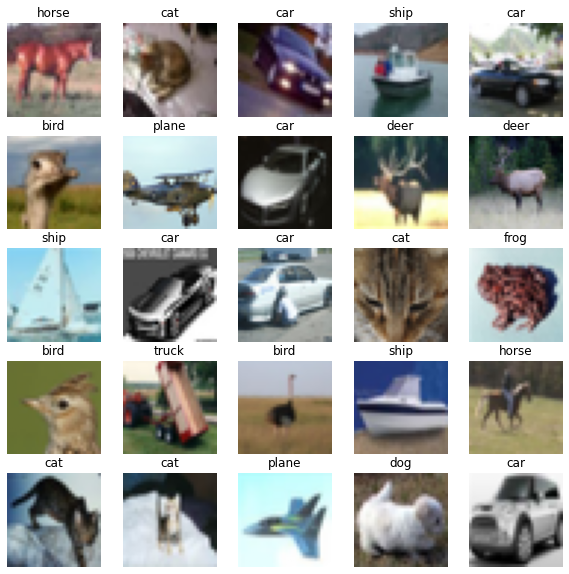

In [ ]:
#Visualize Data
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        img = image_batch[n] / 2 + 0.5     # unnormalize
        img = img.numpy()
        plt.imshow(np.transpose(img, (1, 2, 0)))
        plt.title(CLASS_NAMES[label_batch[n]])
        plt.axis("off")
sample_images, sample_labels = next(iter(trainloader))
show_batch(sample_images, sample_labels)

MODEL

In [ ]:
class Net(nn.Module):
    """
    A 3 layers conv network + 2 feedfoward

    optional you can turn on the <dropoutRule> which is an improvement on the method
    """
    def __init__(self, input_shape=(3,32,32), pDropout=0.25, dropoutRule = False):
        super().__init__()
        self.dropoutRule = dropoutRule
        self.pDropout    = pDropout

        self.conv1 = nn.Conv2d(3, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 128, 3)
    
        self.pool = nn.MaxPool2d(2,2)


        n_size = self._get_conv_output(input_shape)
        self.fc1 = nn.Linear(n_size, 512)
        self.fc2 = nn.Linear(512, 10)
        # Define proportion or neurons to dropout
        self.dropout = nn.Dropout(pDropout)

    def _get_conv_output(self, shape):
        """Feedfoward to know the convolutional output_size"""
        batch_size = 1
        input = torch.autograd.Variable(torch.rand(batch_size, *shape))
        output_conv = self.forward_conv(input)
        n_size = output_conv.data.view(batch_size, -1).size(1)
        return n_size
    def forward_conv(self, x):
        x = self.pool(F.relu(self.conv1(x))) #Conv1
        x = self.pool(F.relu(self.conv2(x))) #Conv2
        x = self.pool(F.relu(self.conv3(x))) #Conv3
        return x

    def forward(self, x):
        x = self.forward_conv(x)
        #Aplanar
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        if self.dropoutRule and self.eval: x *= self.pDropout
        #FF1
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        if self.dropoutRule and self.eval: x *= self.pDropout
        #FF2
        x = self.fc2(x)
        return x

DEFINE TRAINING METHOD

In [ ]:
def train(model, device, train_loader, optimizer, criterion, steps_per_epoch=20):
    model.train()

    nSamples = 0
    train_loss = 0
    train_correct = 0

    for batch_idx, (data, target) in enumerate(train_loader, start=0):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()       
        output = model(data)
        loss = criterion(output, target)
        train_loss += loss.item()

        nSamples += target.size(0)
        scores, predictions = torch.max(output.data, 1)
        train_correct += int(sum(predictions == target))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_accuracy = train_correct / nSamples
    train_loss = train_loss/nSamples
    # wandb.log({"Train Loss": train_loss/train_total, "Train Accuracy": acc, "Epoch": epoch})
    return train_loss, train_accuracy

TEST

In [ ]:
def test(model, device, test_loader, criterion, classes):
    model.eval()

    nSamples = 0
    test_loss = 0
    test_correct = 0

    example_images = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
           
            test_loss += criterion(output, target).item()
            
            scores, predictions = torch.max(output.data, 1)
            test_total += target.size(0)
            test_correct += int(sum(predictions == target))

    test_accuracy = test_correct/nSamples
    test_loss = test_loss/nSamples
    return test_loss, test_accuracy

optional show progress in tensorboard

In [ ]:
%load_ext tensorboard
logdir = 'logs/'
%mkdir $logdir
writter = SummaryWriter(log_dir=logdir)
writter.add_scalar('void',0,0) #test a signal

In [ ]:
%tensorboard --logdir logs

RUN TRAINING AND VALIDATION

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
net_dropout      = Net().to(device)
net_dropout_rule = Net(dropoutRule=True).to(device)
print(net_dropout)

criterion = nn.CrossEntropyLoss()
optimizer_1 = optim.Adam(net_dropout.parameters())
optimizer_2 = optim.Adam(net_dropout_rule.parameters())

hist = {}
hist['train_loss'] = []
hist['train_acc'] = []
hist['test_loss'] = []
hist['test_acc'] = []
hist['train_loss_rule'] = []
hist['train_acc_rule'] = []
hist['test_loss_rule'] = []
hist['test_acc_rule'] = []

for epoch in range(50):
    train_loss, train_accuracy = train(net_dropout, device, trainloader, optimizer_1, criterion)
    test_loss, test_accuracy   = test(net_dropout, device, testloader, criterion, CLASS_NAMES)
    train_loss_rule, train_accuracy_rule = train(net_dropout_rule, device, trainloader, optimizer_2, criterion)
    test_loss_rule, test_accuracy_rule   = test(net_dropout_rule, device, testloader, criterion, CLASS_NAMES)

    print(f"{epoch}: train_Loss: {train_loss:.3}, Accuracy: {train_accuracy:.3}",end='')
    print(f"test_loss: {test_loss:.3}, test_accuracy: {test_accuracy:.3}")
    print(f"{epoch}: train_loss_rule: {train_loss_rule:.3}, Accuracy_rule: {train_accuracy_rule:.3}",end='')
    print(f"test_loss_rule: {test_loss_rule:.3}, test_accuracy_rule: {test_accuracy_rule:.3}")

    hist['train_loss'].append(train_loss)
    hist['test_loss'].append(test_loss)
    hist['train_acc'].append(train_accuracy)
    hist['test_acc'].append(test_accuracy)

    hist['train_loss_rule'].append(train_loss_rule)
    hist['train_acc_rule'].append(train_accuracy_rule)
    hist['test_loss_rule'].append(test_loss_rule)
    hist['test_acc_rule'].append(test_accuracy_rule)

    # writter.add_scalar('train_loss', train_loss, epoch)
    # writter.add_scalar('train_acc', train_accuracy, epoch)
    # writter.add_scalar('val_loss', test_loss, epoch)
    # writter.add_scalar('val_acc', test_accuracy, epoch)

    # writter.add_scalar('train_loss_rule', train_loss_rule, epoch)
    # writter.add_scalar('train_acc_rule', train_accuracy_rule, epoch)
    # writter.add_scalar('val_loss_rule', test_loss_rule, epoch)
    # writter.add_scalar('val_acc_rule', test_accuracy_rule, epoch)

print("Finished Training")

cuda:0
Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)
0: train_Loss: 0.04661326177597046, Accuracy: 45.2test_loss: 0.03932409690618515, test_accuracy: 55.58
0: train_loss_rule: 0.05107603327035904, Accuracy_rule: 39.32test_loss_rule: 0.04363197311162949, test_accuracy_rule: 50.05
1: train_Loss: 0.035257310476899145, Accuracy: 59.91test_loss: 0.03286896331906319, test_accuracy: 63.58
1: train_loss_rule: 0.039603882995843886, Accuracy_rule: 54.27test_loss_rule: 0.03545638924837113, test_accuracy_rule: 59.13
2: train_Loss: 0.030212553994059563, Accuracy: 65.83test_loss: 0.02938654007613659, test_accur

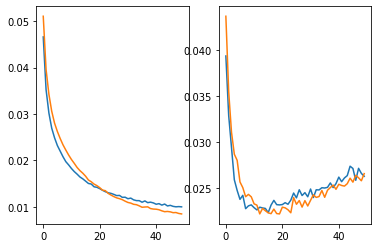

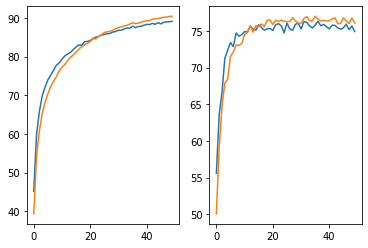

In [ ]:
fig1, (ax1,ax2) = plt.subplots(1,2)
fig2, (ax3,ax4) = plt.subplots(1,2)

ax1.plot(hist['train_loss'])
ax1.plot(hist['train_loss_rule'])
ax2.plot(hist['test_loss'])
ax2.plot(hist['test_loss_rule'])
ax3.plot(hist['train_acc'])
ax3.plot(hist['train_acc_rule'])
ax4.plot(hist['test_acc'])
ax4.plot(hist['test_acc_rule'])